In [1]:
import argparse
import time
import numpy as np
import pandas as pd
from pathlib import Path
from src import regress

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import KFold

from src.tools import corr2d
import src.custom_plotting as cp
from tqdm import tqdm

import nibabel as nib
from statsmodels.stats.multitest import multipletests

from nilearn import plotting, surface, datasets

import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
def load_neural(out_dir, sid, dataset):
    mask = np.load(f'{out_dir}/Reliability/sub-all_set-test_reliability-mask.npy')
    path = f'{out_dir}/GroupRuns/sub-{sid}/sub-{sid}_{dataset}-data.npy'
    beta_map = np.load(path)
    indices = np.where(mask)[0]
    return beta_map[indices, :].T

In [3]:
def scale(a):
    if a.ndim > 1:
        avg = a.mean(axis=0)
        sd = a.std(axis=0)
        sd[np.isclose(sd, 0)] = np.nan
    else:
        avg = a.mean()
        sd = a.std()
    return (a-avg)/sd

In [4]:
# def scale(train, test):
#     if train.ndim > 1:
#         avg = train.mean(axis=0)
#         sd = train.std(axis=0)
#         sd[np.isclose(sd, 0)] = np.nan
#     else:
#         avg = train.mean()
#         sd = train.std()
#     return (train-avg)/sd, (test-avg)/sd

In [5]:
def filter_r(rs, ps, p_crit=0.05, correct=True, threshold=True):
    if correct:
        _, ps_corrected, _, _ = multipletests(ps, method='fdr_bh')
    else:
        ps_corrected = ps.copy()

    if threshold:
        rs[ps_corrected >= p_crit] = 0.
    else:
        rs[rs < 0.] = 0.
    return rs, ps_corrected

In [6]:
def permutation_test_2d(a, b,
                        test_inds=None,
                        n_perm=int(5e3),
                        H0='greater'):
    r_true = corr2d(a, b)

    r_null = np.zeros((n_perm, a.shape[-1]))
    for i in tqdm(range(n_perm), total=n_perm):
        if test_inds is not None:
            inds = np.random.default_rng(i).permutation(test_inds.shape[1])
            inds = test_inds[:, inds].flatten()
        else:
            inds = np.random.default_rng(i).permutation(a.shape[0])
        a_shuffle = a[inds, :]
        r_null[i, :] = corr2d(a_shuffle, b)

    #Get the p-value depending on the type of test
    if H0 == 'two_tailed':
        p = np.sum(np.abs(r_null) >= np.abs(r_true), axis=0) / n_perm
    elif H0 == 'greater':
        p = 1 - (np.sum(r_true > r_null, axis=0) / n_perm)
    else:# H0 == 'less':
        p = 1 - (np.sum(r_true < r_null, axis=0) / n_perm)
    return r_true, p, r_null

In [7]:
fsaverage = datasets.fetch_surf_fsaverage()
cmap = sns.color_palette('magma', as_cmap=True)

In [8]:
sid = '01'
data_dir='/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/raw'
out_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/interim'

In [9]:
mask_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/interim/Reliability'
mask_im = nib.load(f'{mask_dir}/sub-all_set-test_stat-rho_statmap.nii.gz')
mask = np.load(f'{mask_dir}/sub-all_set-test_reliability-mask.npy')

In [10]:
ind = 150
dataset = 'train'
# X_train = np.load(f'{out_dir}/GenerateModels/control_model_conv2_set-train.npy')
# X_test = np.load(f'{out_dir}/GenerateModels/control_model_conv2_set-test.npy')
X = np.load(f'{out_dir}/GenerateModels/control_model_conv2_set-{dataset}.npy')
X_train = X[:ind, :]
X_test = X[ind:, :]

In [11]:
# y_train = load_neural(out_dir, sid, 'train')
# y_test = load_neural(out_dir, sid, 'test')
y = load_neural(out_dir, sid, dataset)
y_train = y[:ind, :]
y_test = y[ind:, :]

In [12]:
# X_train, X_test = scale(X_train, X_test)
# y_train, y_test = scale(y_train, y_test)

In [13]:
X_train = scale(X_train)
X_test = scale(X_test)
y_train = scale(y_train)
y_test = scale(y_test)

In [14]:
alphas = 10. ** np.arange(start=-2., stop=6.)
kf = KFold(n_splits=4, shuffle=True, random_state=0)
clf = RidgeCV(cv=kf, scoring="r2", alphas=alphas)
clf.fit(X_train, y_train)
alpha = clf.alpha_
print(alpha)

1000.0


In [15]:
lr = Ridge(fit_intercept=False, alpha=alpha)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [16]:
r_true, p, r_null = permutation_test_2d(y_pred, y_test, n_perm=100)

100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


In [17]:
r_true, p_corrected = filter_r(r_true, p, threshold=True)
volume = cp.mkNifti(r_true, mask, mask_im)
texture = {'left': surface.vol_to_surf(volume, fsaverage['pial_left']),
           'right': surface.vol_to_surf(volume, fsaverage['pial_right'])}

/Applications/anaconda3/envs/nibabel/lib/python3.10/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



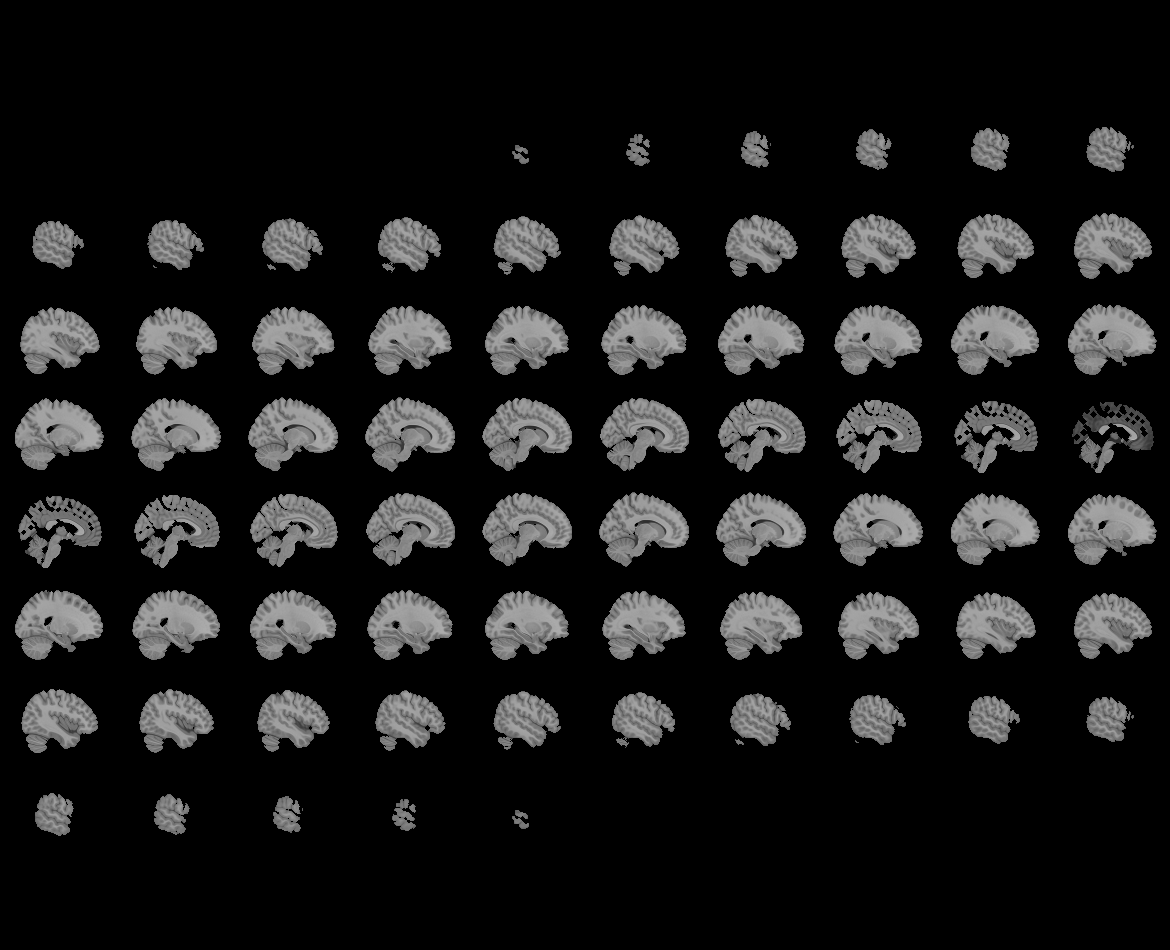
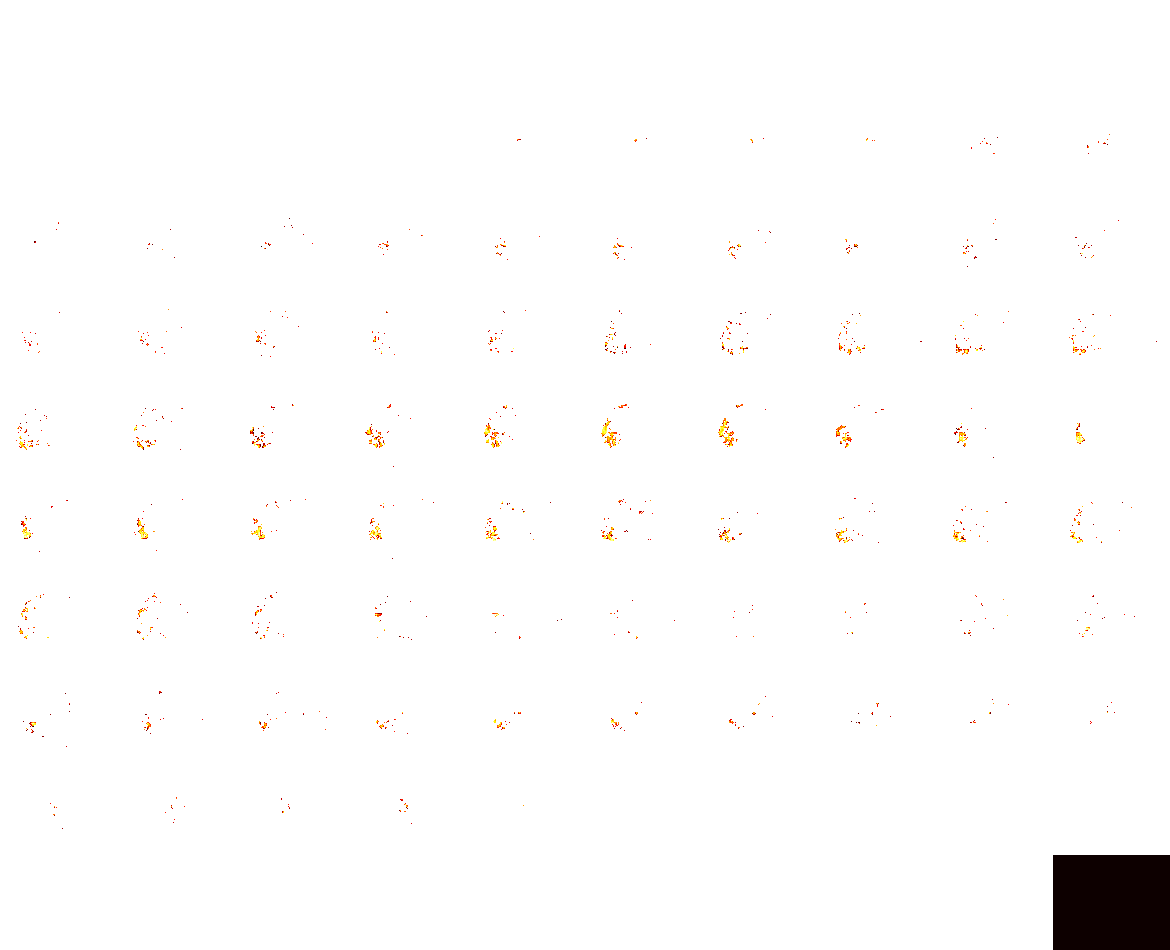

In [18]:
plotting.view_img(volume)

In [19]:
hemi = 'right'
plotting.view_surf(fsaverage[f'infl_{hemi}'],
                   texture[hemi],
                   bg_map=fsaverage[f'sulc_{hemi}'],
                   symmetric_cmap=False,
                   threshold=0.01, vmax=1,
                   cmap=cmap)